In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import interpolate

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import joblib

import tensorflow as tf
from tensorflow import keras
import pickle

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [5]:
train_data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [6]:
test_data.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4


<b> Employee ID:</b> The unique ID allocated for each employee (example: fffe390032003000)

<b>Date of Joining:</b> The date-time when the employee has joined the organization (example: 2008-12-30)

<b>Gender:</b> The gender of the employee (Male/Female)

<b>Company Type:</b> The type of company where the employee is working (Service/Product)

<b>WFH Setup Available:</b> Is the work from home facility available for the employee (Yes/No)

<b>Designation:</b> The designation of the employee of work in the organization.
In the range of [0.0, 5.0] bigger is higher designation.

<b>Resource Allocation:</b> The amount of resource allocated to the employee to work, ie. number of working hours.
In the range of [1.0, 10.0] (higher means more resource)

<b>Mental Fatigue Score:</b> The level of fatigue mentally the employee is facing.
In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

<b>Burn Rate:</b> The value we need to predict for each employee telling the rate of Bur out while working.
In the range of [0.0, 1.0] where the higher the value is more is the burn out.

In [7]:
print("Dimensions of training data ", train_data.shape)
print("Dimensions of testing data ", test_data.shape)

Dimensions of training data  (22750, 9)
Dimensions of testing data  (12250, 8)


In [8]:
train_data.isnull().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

<b> As a part of preprocessing certain things are to be done </b>

1. Convert string or character values to encoded values.

2. Find the correlation between each of the fields which can help in filling NaN.

3. Fill NAN for <b>Resource Allocation</b> by comparing with <b>Designation</b>.

4. Remove all rows where both <b>Mental Fatigue Score</b> and <b>Burn Rate</b> were empty as each is dependent on another.

5. Interpolate the missing <b>Mental Fatigue Score</b> and <b> Burn Rate </b> values.

6. Finally delete all other rows which have NaN values.

In [9]:
# Perform encoding of categorical data before imputing the other missing values

# creating instance of labelencoder
labelencoder = LabelEncoder()

gender_encoded_train = labelencoder.fit_transform(train_data['Gender'])
gender_encoded_test = labelencoder.fit_transform(test_data['Gender'])
# Female = 0 , # Male = 1

wfh_setup_encoded_train = labelencoder.fit_transform(train_data['WFH Setup Available'])
wfh_setup_encoded_test = labelencoder.fit_transform(test_data['WFH Setup Available'])
# No = 0, # Yes = 1

company_type_encoded_train = labelencoder.fit_transform(train_data['Company Type'])
company_type_encoded_test = labelencoder.fit_transform(test_data['Company Type'])
# Product = 0, # Service = 1

In [10]:
train_data.insert(loc=2, column='Gender_Encoded', value=gender_encoded_train)
train_data.insert(loc=3, column='WFH_Setup_Encoded', value=wfh_setup_encoded_train)
train_data.insert(loc=4, column='Company_Type_Encoded', value=company_type_encoded_train)

train_data.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

test_data.insert(loc=2, column='Gender_Encoded', value=gender_encoded_test)
test_data.insert(loc=3, column='WFH_Setup_Encoded', value=wfh_setup_encoded_test)
test_data.insert(loc=4, column='Company_Type_Encoded', value=company_type_encoded_test)

test_data.drop(columns=["Gender", "Company Type", "WFH Setup Available"], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Gender_Encoded'}>,
        <AxesSubplot:title={'center':'WFH_Setup_Encoded'}>,
        <AxesSubplot:title={'center':'Company_Type_Encoded'}>],
       [<AxesSubplot:title={'center':'Designation'}>,
        <AxesSubplot:title={'center':'Resource Allocation'}>,
        <AxesSubplot:title={'center':'Mental Fatigue Score'}>],
       [<AxesSubplot:title={'center':'Burn Rate'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

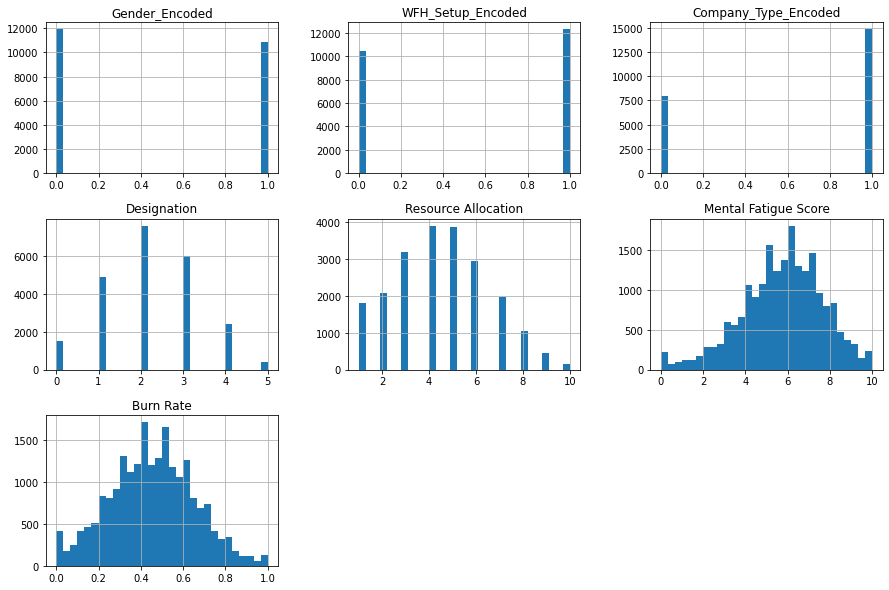

In [11]:
train_data.hist(bins=30, figsize=(15, 10))

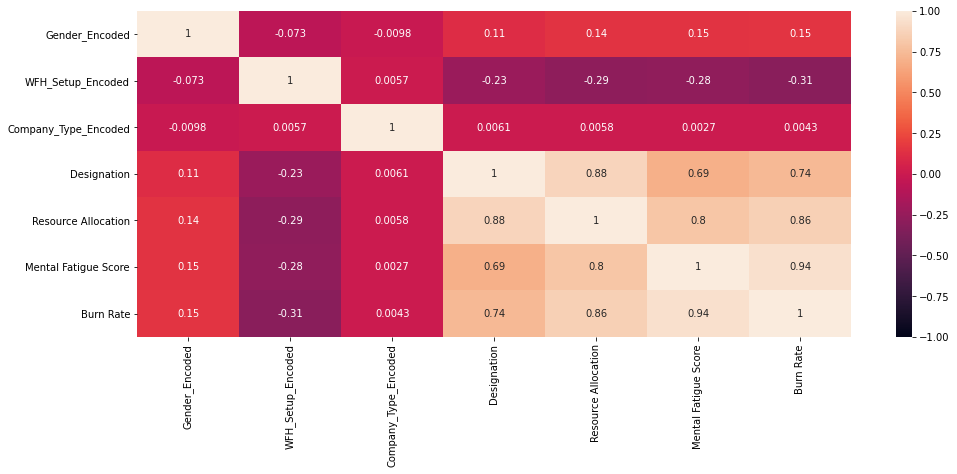

In [14]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train_data.corr(), vmin=-1, vmax=1, annot=True)

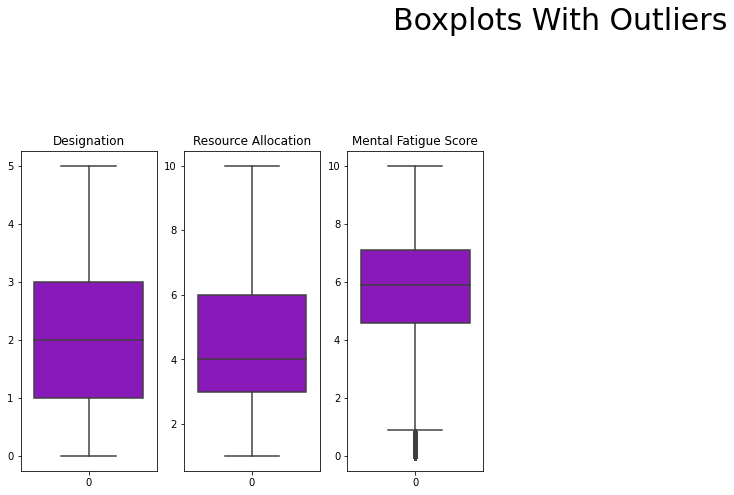

In [18]:
eda_df = train_data.drop(columns=['Burn Rate','Employee ID','Date of Joining'], axis=1).copy()
nonbinary_columns = [column for column in eda_df.columns if len(eda_df[column].unique()) > 2]

plt.figure(figsize=(20, 20))

for i, column in enumerate(nonbinary_columns):
    plt.subplot(3, 7, i + 1)
    sns.boxplot(data=eda_df[column], color='darkviolet')
    plt.title(column)

plt.suptitle("Boxplots With Outliers", size=30)
plt.show()

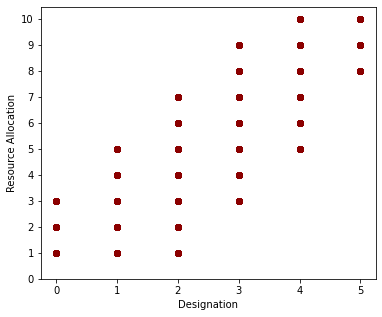

In [19]:
# Now to fill the resource allocation column, it is heavily correlated with the designation
# Hence filling the values of resource allocation accordingly


plt.figure(figsize=(6, 5))
plt.scatter("Designation", "Resource Allocation", data=train_data, c="darkred")
plt.xlabel("Designation")
plt.ylabel("Resource Allocation")
plt.yticks(range(0,11))
plt.show()

In [20]:
# Get min, max, mean, median values for each designation and resource allocation correlation

for i in range(6):    # 0 to 5, Designation values
    temp_value = train_data["Resource Allocation"][train_data["Designation"]==i]
    indices = (train_data["Designation"]==i) & train_data["Resource Allocation"].isna()
    print(temp_value.value_counts())
    
    # As resource allocation has considerable amount of impact on burnout rate
    # Fill accordingly either as mean or median
    train_data.loc[indices, "Resource Allocation"] = temp_value.median()


1.0    1142
2.0     262
3.0      17
Name: Resource Allocation, dtype: int64
3.0    1682
2.0    1475
4.0     735
1.0     635
5.0      59
Name: Resource Allocation, dtype: int64
4.0    2564
5.0    2009
3.0    1479
6.0     652
2.0     338
7.0      52
1.0      14
Name: Resource Allocation, dtype: int64
6.0    1952
5.0    1783
7.0    1056
4.0     594
8.0     224
3.0      14
9.0       7
Name: Resource Allocation, dtype: int64
7.0     857
8.0     757
6.0     339
9.0     263
10.0     25
5.0      10
Name: Resource Allocation, dtype: int64
9.0     176
10.0    134
8.0      63
Name: Resource Allocation, dtype: int64


In [21]:
train_data.isnull().sum()

Employee ID                0
Date of Joining            0
Gender_Encoded             0
WFH_Setup_Encoded          0
Company_Type_Encoded       0
Designation                0
Resource Allocation        0
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [22]:
# Remove fields that have both burnout and mental fatigue as NAN. 
# This is because, mental fatigue is directly correlated to burnout. A double NAN would be a problem

mental_fatigue_nan = train_data["Mental Fatigue Score"].isna()
burn_rate_nan = train_data["Burn Rate"].isna()
fatigue_burnout_nan_indices = train_data[burn_rate_nan & mental_fatigue_nan].index

print("Number of rows with both fatigue and burnout as null ", fatigue_burnout_nan_indices.shape)

train_data.drop(index = fatigue_burnout_nan_indices, axis = 0, inplace = True)
train_data.isnull().sum()

Number of rows with both fatigue and burnout as null  (172,)


Employee ID                0
Date of Joining            0
Gender_Encoded             0
WFH_Setup_Encoded          0
Company_Type_Encoded       0
Designation                0
Resource Allocation        0
Mental Fatigue Score    1945
Burn Rate                952
dtype: int64

In [23]:
# function to find the burn rate
fn_burn = interpolate.interp1d(x=train_data["Mental Fatigue Score"], 
                               y=train_data["Burn Rate"], 
                               kind="linear", 
                               fill_value=None)
# function to find the mental fatigue score
fn_mental = interpolate.interp1d(y=train_data["Mental Fatigue Score"], 
                                 x=train_data["Burn Rate"], 
                                 kind="linear", 
                                 fill_value=None)

In [24]:
# get rid of these NaNs
for i in train_data[train_data["Burn Rate"].isna()].index:
    train_data.loc[i, "Burn Rate"] = fn_burn(train_data.loc[i, "Mental Fatigue Score"])
    
for i in train_data[train_data["Mental Fatigue Score"].isna()].index:
    train_data.loc[i, "Mental Fatigue Score"] = fn_mental(train_data.loc[i, "Burn Rate"])

In [25]:
train_data.isnull().sum()

Employee ID               0
Date of Joining           0
Gender_Encoded            0
WFH_Setup_Encoded         0
Company_Type_Encoded      0
Designation               0
Resource Allocation       0
Mental Fatigue Score    201
Burn Rate                79
dtype: int64

In [26]:
# Now remove all rows which have NaN. Best possible level of data imputation has been performed
train_data = train_data.dropna()

# Remove the Date-of-Joining column as it is not influential to our model
train_data.drop(['Date of Joining'], axis=1, inplace=True)
test_data.drop(['Date of Joining'], axis=1, inplace=True)
train_data.shape

(22298, 8)

In [18]:
train_data.head()

,Employee ID,Gender_Encoded,WFH_Setup_Encoded,Company_Type_Encoded,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,0,0,1,2.0,3.0,3.8,0.16
1,fffe3700360033003500,1,1,1,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,0,1,0,2.0,4.0,5.8,0.49
3,fffe32003400380032003900,1,1,1,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,0,0,1,3.0,7.0,6.9,0.52


In [27]:
# START Processing of the data

X = train_data.iloc[:, 1:-1]
Y = train_data.iloc[:, -1]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.25, shuffle = True)

X_test = test_data.iloc[:, 1:]
Y_test = None
print("Train Data dimensions ", X_train.shape, " --- " , Y_train.shape)
print("Validation Data dimensions ", X_validation.shape, " --- ", Y_validation.shape)
print("Test Data dimensions ", X_test.shape, " --- ")

Train Data dimensions  (16723, 6)  ---  (16723,)
Validation Data dimensions  (5575, 6)  ---  (5575,)
Test Data dimensions  (12250, 6)  --- 


In [29]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
y_pred = reg.predict(X_validation)
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_validation, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_validation, y_pred))

print(max(0,100-np.sqrt(mean_squared_error(Y_validation,y_pred))))

Coefficients: 
 [ 0.0038488  -0.01122518  0.00114286 -0.00510233  0.02696336  0.07576143]
Mean squared error: 0.00
Coefficient of determination: 0.92
99.94272204459601


In [34]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.5).fit(X_train, Y_train)
y_pred_rid = ridge.predict(X_validation)

from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_validation, y_pred_rid))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_validation, y_pred_rid))

print(max(0,100-np.sqrt(mean_squared_error(Y_validation,y_pred_rid))))

Coefficients: 
 [ 0.0038488  -0.01122518  0.00114286 -0.00510233  0.02696336  0.07576143]
Mean squared error: 0.00
Coefficient of determination: 0.92
99.94272210021114


In [35]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.096).fit(X_train, Y_train)
y_pred_las = lasso.predict(X_validation)

from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_validation, y_pred_las))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_validation, y_pred_las))

print(max(0,100-np.sqrt(mean_squared_error(Y_validation,y_pred_las))))

Coefficients: 
 [ 0.0038488  -0.01122518  0.00114286 -0.00510233  0.02696336  0.07576143]
Mean squared error: 0.01
Coefficient of determination: 0.85
99.9225172351758


In [24]:
NN_model = keras.Sequential()

# The Input Layer :
NN_model.add(keras.layers.Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(keras.layers.Dense(256, kernel_initializer='normal',activation='softmax'))
NN_model.add(keras.layers.Dense(256, kernel_initializer='normal',activation='softmax'))
NN_model.add(keras.layers.Dense(256, kernel_initializer='normal',activation='softmax'))

# The Output Layer :
NN_model.add(keras.layers.Dense(1, kernel_initializer='normal',activation='sigmoid'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [25]:
NN_model.fit(X_train, Y_train, epochs = 75, validation_data = (X_validation, Y_validation))

Train on 16824 samples, validate on 5609 samples
Epoch 1/75
16824/16824 [==============================] - 2s 137us/sample - loss: 0.1594 - mean_absolute_error: 0.1594 - val_loss: 0.1595 - val_mean_absolute_error: 0.1595
Epoch 2/75
16824/16824 [==============================] - 2s 128us/sample - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1595 - val_mean_absolute_error: 0.1595
Epoch 3/75
16824/16824 [==============================] - 2s 124us/sample - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1595 - val_mean_absolute_error: 0.1595
Epoch 4/75
16824/16824 [==============================] - 2s 140us/sample - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1595 - val_mean_absolute_error: 0.1595
Epoch 5/75
16824/16824 [==============================] - 2s 126us/sample - loss: 0.1590 - mean_absolute_error: 0.1590 - val_loss: 0.1594 - val_mean_absolute_error: 0.1594
Epoch 6/75
16824/16824 [==============================] - 2s 128us/sample - loss: 0.1543 - 

In [26]:
Y_test = NN_model.predict(X_validation)

In [27]:
print(mean_absolute_error(Y_validation, NN_model.predict(X_validation).reshape(-1)))

0.04478363309788139


In [28]:
# serialize model to JSON
model_json = NN_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
NN_model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [29]:
tf.keras.models.save_model(NN_model, "whole_model")